We begin by importing the necessary libraries and modules for our project

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

Below we set the device (either GPU or CPU) will be used for computations in PyTorch

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# # Define data transforms
# data_transforms = {
#     'C:/Users/USER/Desktop/Ezekiel 3/brain-tumor-detection/train': transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'C:/Users/USER/Desktop/Ezekiel 3/brain-tumor-detection/val': transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
# }

# # Load the datasets
# data_dir = 'C:/Users/USER/Desktop/Ezekiel 3/brain-tumor-detection/my dataset'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

This code below prepares the data transformations and loads the training and validation datasets from the specified directory, applying the appropriate transformations to each set. 

- import the datasets module from the torchvision library, which provides access to popular datasets like ImageNet, CIFAR, and others.

- define the transformations to be applied to the training and validation datasets. The transforms.Compose function combines multiple transformations into a single operation.

- transforms.Resize((224, 224)) resizes the images to 224x224 pixels.
transforms.RandomHorizontalFlip() randomly flips the images horizontally for data augmentation.
transforms.ToTensor() converts the PIL images to PyTorch tensors.
transforms.Normalize normalizes the tensor images with mean and standard deviation values typical for ImageNet.

In [3]:
from torchvision import datasets

# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load the datasets
data_dir = 'C:/Users/USER/Desktop/Ezekiel 3/brain-tumor-detection/my dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}


PyTorch's DataLoader is used to create data loaders for both the training and validation datasets. The DataLoader handles batching the data, shuffling the training data, and provides an efficient way to iterate over the data during training and evaluation.PyTorch's DataLoader is used to create data loaders for both the training and validation datasets. The DataLoader handles batching the data, shuffling the training data, and provides an efficient way to iterate over the data during training and evaluation.

In [4]:
# Create data loaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True) for x in ['train', 'val']}

The neural network architecture below is a basic convolutional neural network (CNN) with two convolutional layers, two max pooling layers, and two fully connected layers. The input to the network is expected to be a 3-channel image (likely RGB), and the output is a tensor of size 2, representing the predicted probabilities for the two classes (tumor or non-tumor).

In [5]:
# Define the CNN Model
class BrainTumorDetector(nn.Module):
    def __init__(self):
        super(BrainTumorDetector, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.pool(out)
        out = self.relu(self.conv2(out))
        out = self.pool(out)
        out = out.view(-1, 64 * 56 * 56)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

- BrainTumorDetector() creates a new instance of the BrainTumorDetector class, which is the convolutional neural network model defined earlier for brain tumor detection.

- .to(device) moves the newly created model instance to the device specified by the device variable. Recall that device was set earlier to either 'cuda' (GPU) or 'cpu' (CPU), depending on the availability of a CUDA-enabled GPU.

In [6]:
# Initialize the model
model = BrainTumorDetector().to(device)

These two lines of code below define the loss function and the optimizer for training the neural network model.

In [7]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

This code below defines the function train_model that handles the training and validation of the neural network model over multiple epochs. Here's a Breakdown:


- The function takes four arguments: model (the model to be trained), criterion (the loss function), optimizer (the optimization algorithm), and num_epochs (the number of epochs to train for, default is 25).

- It initializes four empty lists: train_loss_history, val_loss_history, train_acc_history, and val_acc_history. These lists will store the training loss, validation loss, training accuracy, and validation accuracy, respectively, for each epoch.

- It starts a loop over the specified number of epochs (num_epochs).

- Inside the loop, it resets the training loss, validation loss, training accuracy, and validation accuracy to 0 for each epoch.

- It sets the model to training mode using model.train().

- It iterates over the training data loader (dataloaders['train']) and performs the following steps for each batch of data:

Move the input data (inputs) and labels (labels) to the specified device (device).
Reset the gradients to zero using optimizer.zero_grad().
Perform a forward pass through the model to obtain the output (outputs = model(inputs)).
Calculate the loss using the loss function (loss = criterion(outputs, labels)).
Perform backpropagation to compute the gradients (loss.backward()).
Update the model's parameters using the optimizer (optimizer.step()).
Update the training loss and training accuracy for the current batch.


- It sets the model to evaluation mode using model.eval().

- It iterates over the validation data loader (dataloaders['val']) and performs the following steps for each batch of data:

Move the input data (inputs) and labels (labels) to the specified device (device).
Perform a forward pass through the model to obtain the output (outputs = model(inputs)).
Calculate the loss using the loss function (loss = criterion(outputs, labels)).
Update the validation loss and validation accuracy for the current batch.


It calculates the average training loss, validation loss, training accuracy, and validation accuracy for the entire epoch by dividing the accumulated values by the respective dataset lengths.
It appends the average training loss, validation loss, training accuracy, and validation accuracy to their respective history lists.

- It appends the average training loss, validation loss, training accuracy, and validation accuracy to their respective history lists.

- It prints the current epoch number, training loss, validation loss, training accuracy, and validation accuracy.

- After the training loop is completed, the function returns the lists containing the training loss history, validation loss history, training accuracy history, and validation accuracy history.

In [31]:
# Training and validation functions
def train_model(model, criterion, optimizer, num_epochs=25):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0

        # Training loop
        model.train()
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)

        # Validation loop
        model.eval()
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)

        train_loss /= len(dataloaders['train'].dataset)
        val_loss /= len(dataloaders['val'].dataset)
        train_acc /= len(dataloaders['train'].dataset)
        val_acc /= len(dataloaders['val'].dataset)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

The Code below does the following:

- num_epochs = 20 sets the number of epochs for training to 20. An epoch is one complete pass through the entire training dataset.
The train_model function (defined earlier) is called with the following arguments:

- model: The instance of the BrainTumorDetector model that was initialized earlier.
criterion: The loss function (cross-entropy loss) that was defined earlier.
optimizer: The optimizer (SGD with momentum) that was defined earlier.
num_epochs: The number of epochs to train for (20 in this case).


- The train_model function performs the training and validation of the model over the specified number of epochs (num_epochs). It iterates over the training and validation data loaders, computes the loss, updates the model parameters using the optimizer, and keeps track of the training and validation metrics (loss and accuracy) for each epoch.

- The train_model function returns four lists: train_loss_history, val_loss_history, train_acc_history, and val_acc_history. These lists contain the training loss, validation loss, training accuracy, and validation accuracy, respectively, for each epoch.

- The returned lists are unpacked and assigned to the corresponding variables: train_loss_history, val_loss_history, train_acc_history, and val_acc_history.

In [32]:
# Train the model
num_epochs = 20
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(model, criterion, optimizer, num_epochs)

KeyboardInterrupt: 

This code below creates a line plot with two lines: one representing the training loss over epochs (in blue), and the other representing the validation loss over epochs (in orange). The x-axis shows the epoch numbers, and the y-axis shows the corresponding loss values.

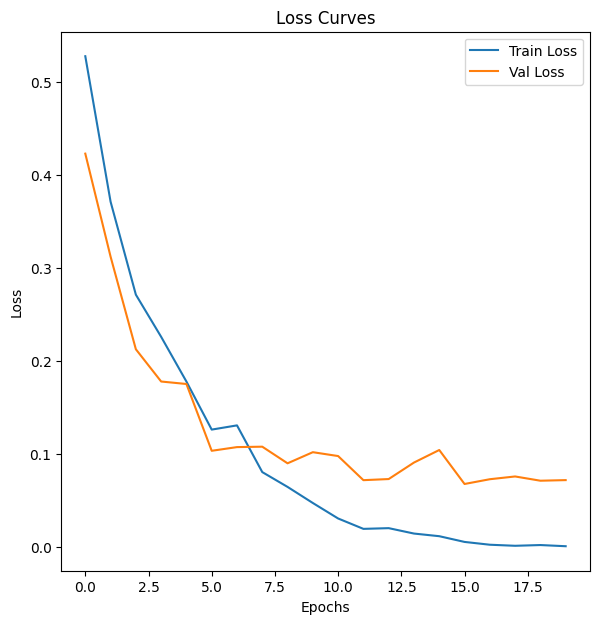

In [ ]:
# Plot the training and validation curves
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss_history, label='Train Loss')
plt.plot(range(num_epochs), val_loss_history, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

- In the above Graph, the training loss is consistently lower than the validation loss throughout the epochs, which is a good sign and suggests that the model is learning from the training data.

- Both the training loss and validation loss are decreasing throughout the epochs. This is a positive sign, as it indicates that the model is learning.

This code below creates a line plot with two lines: one representing the training accuracy over epochs (in blue), and the other representing the validation accuracy over epochs (in orange). The x-axis shows the epoch numbers, and the y-axis shows the corresponding accuracy values.

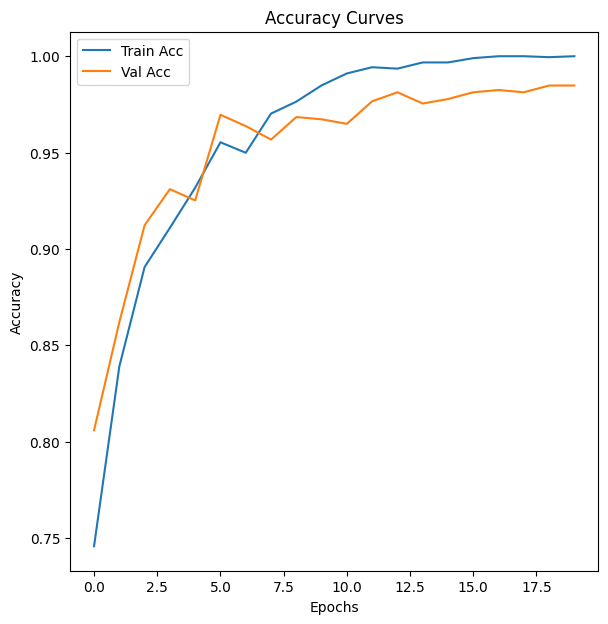

In [16]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc_history, label='Train Acc')
plt.plot(range(num_epochs), val_acc_history, label='Val Acc')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

- From the above Graph, we can see that the validation accuracy appears to be around 0.85, which is relatively high. This indicates that the model is performing well on unseen data.

- The training accuracy is increasing throughout the epochs, which suggests the model is learning from the training data.

This code below defines the function test_model that evaluates the performance of the trained model on the test dataset

In [17]:
# Testing the model
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

This line of code below calls the test_model function to evaluate the performance of the trained model on the validation dataset & displays the accuracy of the trained model

In [18]:
# Test the model on the validation set
test_model(model, dataloaders['val'])

Test Accuracy: 0.9848


This line of code below saves the trained state of the neural network model to the file named "brain_tumor_detector.h5."

In [33]:
import torch

# Assuming you have your PyTorch model defined in a variable named 'model'

def save_pytorch_model(model, save_path):
  """Saves a PyTorch model to the specified path in the .pt format.

  Args:
      model (torch.nn.Module): The PyTorch model to save.
      save_path (str): The path to save the model state dictionary.
  """

  # Save only the model's state dictionary (parameters and optimizer states)
  torch.save(model.state_dict(), save_path)

  print(f"Model saved successfully to: {save_path}")

# Example usage:
save_path = "brain_tumor_detector.pt"  # Replace with your desired filename
save_pytorch_model(model, save_path)

Model saved successfully to: brain_tumor_detector.pt


In [19]:
# Save the model
torch.save(model.state_dict(), 'brain_tumor_detector.h5')

This line of Code below loads the model weights and prepares it for making predictions on new data.

In [20]:
# Load the trained model 
model = BrainTumorDetector().to(device)
model.load_state_dict(torch.load('brain_tumor_detector.h5'))
model.eval()

BrainTumorDetector(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)

The Code below prepares the input image for compatibility with the pre-trained model by resizing, converting to the appropriate format (tensor), and normalizing pixel values.

In [25]:
from PIL import Image
from torchvision import transforms



# Define the transformation for the input image
input_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

This code below defines a function test_image that takes an image path as input and uses the pre-trained brain tumor detection model to predict whether the image shows a brain tumor or not.

In [30]:

# Function to test the model on a single image
def test_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = input_transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        
    if pred.item() == 0:
        print(f"The image '{image_path}' does not show any brain tumor.")
    else:
        print(f"The image '{image_path}' shows a brain tumor.")

# Example usage
test_image('C:/Users/USER/Desktop/Ezekiel 3/brain-tumor-detection/my dataset/no/47 no.jpg')

The image 'C:/Users/USER/Desktop/Ezekiel 3/brain-tumor-detection/my dataset/no/47 no.jpg' does not show any brain tumor.
